In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fig_style import *

import sys
sys.path.insert(0,'../')
from disk_model import DiskFitting, DiskImage, au, pc

In [2]:
import astropy.table
data = astropy.table.Table.read("../data/VANDAM_T20_properties.txt", format="ascii")
data.add_index('Source')

In [3]:
def get_central_flux(I, img, R0 = 20):
    N = img.shape[0]
    x = (np.arange(N)-N//2) * I.au_per_pix
    x,y = np.meshgrid(x,x)
    r = np.sqrt(x**2+y**2)
    F_center = np.sum(img*(r<R0))/np.sum(r<R0)
    return F_center

def get_sp_ind_center(D, is_model=True, err_threshold=3):
    Ia = D.disk_image_list[0]
    Iv = D.disk_image_list[1]
    if is_model:
        imga = Ia.img_model; imgv = Iv.img_model
    else:
        imga = Ia.img; imgv = Iv.img
    F1 = get_central_flux(Ia, imga)
    F2 = get_central_flux(Iv, imgv)
    nu1, nu2 = 1/0.087, 1/0.9 # arbitrary normalization
    sp_ind = np.log(F1/F2)/np.log(nu1/nu2)
    if (not is_model) and (F2<err_threshold*Iv.rms_Jy or F1<err_threshold*Ia.rms_Jy):
        return np.nan
    return sp_ind

def get_sp_ind(D, is_model=True):
    Ia = D.disk_image_list[0]
    Iv = D.disk_image_list[1]
    if is_model:
        # arbitrary normalization
        Fa = np.sum(Ia.img_model)*Ia.au_per_pix**2/Ia.beam_area
        Fv = np.sum(Iv.img_model)*Iv.au_per_pix**2/Iv.beam_area
        Fae,Fve=0,0
    else:
        #Fa = np.sum(Ia.img)*Ia.au_per_pix**2; Fv = np.sum(Iv.img)*Iv.au_per_pix**2; Fae,Fve=0,0
        i = data.loc_indices[D.source_name]
        Fa = data['A_Flux'][i]*1e-3; Fv = data['V_Flux'][i]*1e-3
        if not (Fa>0 and Fv>0):
            print(Fa,Fv)
        Fae = data['A_e_Flux'][i]*1e-3; Fve = data['V_e_Flux'][i]*1e-3
        #R0 = max(2*D.disk_model.Rd/au, 2*data['RdiskA'][i])
        #R0 = data['RdiskA'][i] + 50
        #Fa = get_central_flux(Ia, Ia.img, R0 = R0)
        #Fv = get_central_flux(Iv, Iv.img, R0 = R0)
        #Fae, Fve = 0,0
    nu1, nu2 = 1/0.087, 1/0.9 # arbitrary normalization
    sp_ind = np.log(Fa/Fv)/np.log(nu1/nu2)
    if (not is_model) and (Fa<3*Fae or Fv<3*Fve):
        return np.nan
    return sp_ind

def get_sp_ind_all(D):
    a_cent_obs = get_sp_ind_center(D, is_model=False, err_threshold=3)
    a_cent = get_sp_ind_center(D)
    a_obs = get_sp_ind(D, is_model=False)
    a = get_sp_ind(D)
    if np.isnan(a_cent_obs):
        return [np.nan]*4
    return a_cent_obs, a_cent, a_obs, a

In [4]:
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl','rb') as f:
    Ds = pickle.load(f)
alpha_fid = np.array([get_sp_ind_all(D) for D in Ds])
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5_alma_only.pkl','rb') as f:
    Ds_alma = pickle.load(f)
alpha_alma = np.array([get_sp_ind_all(D) for D in Ds_alma])
with open('../data/fitted_systems/fit_1mm_Q3_age1e5.pkl','rb') as f:
    Ds_Q3 = pickle.load(f)
alpha_Q3 = np.array([get_sp_ind_all(D) for D in Ds_Q3])
with open('../data/fitted_systems/fit_1mm_Q10_age1e5.pkl','rb') as f:
    Ds_Q10 = pickle.load(f)
alpha_Q10 = np.array([get_sp_ind_all(D) for D in Ds_Q10])
with open('../data/fitted_systems/fit_1mm_Q100_age1e5.pkl','rb') as f:
    Ds_Q100 = pickle.load(f)
alpha_Q100 = np.array([get_sp_ind_all(D) for D in Ds_Q100])

with open('../data/fitted_systems/fit_1mm_Q1_age1e5.pkl','rb') as f:
    Ds_Q1 = pickle.load(f)
alpha_Q1 = np.array([get_sp_ind_all(D) for D in Ds_Q1])

/tmp/ipykernel_3807062/17274868.py:19: RuntimeWarning: invalid value encountered in log
  sp_ind = np.log(F1/F2)/np.log(nu1/nu2)


In [5]:
def plot_hist(y, leave_tick_labels=False, **kwargs):
    bins = np.linspace(0, 5, 26)
    if 'histtype' not in kwargs:
        kwargs['histtype'] = 'stepfilled'
    y = y[~np.isnan(alpha_fid[:,2])]
    plt.hist(y, bins=bins, density=True, alpha=1, **kwargs)
    plt.xlim(1,4.8)
    set_ticks()
    if not leave_tick_labels:
        plt.gca().set_xticklabels([])
    plt.gca().set_yticks([])
    yl = plt.ylim()
    yl = (yl[0], yl[1]*1.25)
    #yl = [0,5]
    plt.plot([2,2],yl,'k:', lw=.5)
    #plt.plot([np.nanmedian(y), np.nanmedian(y)],yl,ls=':', color=kwargs['color'])
    plt.plot([4.36,4.36],yl,'k:', lw=.5)
    plt.ylim(yl)
    print(np.nanmedian(y), np.nanmean(y))

# Spectral index of whole disk

2.270680817093659 2.2891111971912497
2.3745448982443356 2.360861027857806
2.496358876082931 2.4485101283623854
2.6943124950481536 2.629720895299629
3.1924164876050707 3.111821764689284


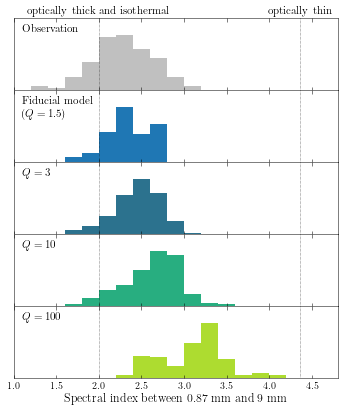

In [48]:
n_panel = 5
fig = plt.figure(figsize=(4.5,n_panel*1))
h = 1/n_panel

N = 4
import matplotlib
colors = matplotlib.cm.get_cmap('viridis')((np.arange(N)+0.5)/N)

ax = fig.add_axes([0,h*4,1,h])
plot_hist(alpha_fid[:,2], color='silver')
plt.text(1.1, plt.ylim()[1]*0.9, 'Observation', ha='left', va='top')
plt.text(2, plt.ylim()[1]*1.05, 'optically thick and isothermal', ha='center')
plt.text(4.36, plt.ylim()[1]*1.05, 'optically thin', ha='center')

ax = fig.add_axes([0,h*3,1,h])
plot_hist(alpha_fid[:,3], color='tab:blue')
plt.text(1.1, plt.ylim()[1]*0.9, 'Fiducial model\n($Q=1.5$)', ha='left', va='top')

ax = fig.add_axes([0,h*2,1,h])
plot_hist(alpha_Q3[:,3], color=colors[1])
plt.text(1.1, plt.ylim()[1]*0.9, '$Q=3$', ha='left', va='top')

ax = fig.add_axes([0,h,1,h])
plot_hist(alpha_Q10[:,3], color=colors[2])
plt.text(1.1, plt.ylim()[1]*0.9, '$Q=10$', ha='left', va='top')

ax = fig.add_axes([0,0,1,h])
plot_hist(alpha_Q100[:,3], leave_tick_labels=True, color=colors[3])
plt.text(1.1, plt.ylim()[1]*0.9, '$Q=100$', ha='left', va='top')

plt.xlabel('Spectral index between 0.87 mm and 9 mm')
#plt.savefig('../figures/spectral_index_Q.pdf',bbox_inches='tight')

/tmp/ipykernel_2157427/17274868.py:19: RuntimeWarning: invalid value encountered in log
  sp_ind = np.log(F1/F2)/np.log(nu1/nu2)


2.270680817093659 2.2891111971912497
2.3745448982443356 2.360861027857806
2.3516065960975787 2.321585312487978
2.5169514152245904 2.49368460909396


Text(0.5, 0, 'Spectral index between 0.87 mm and 9 mm')

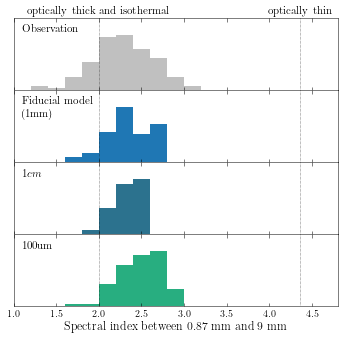

In [49]:
with open('../data/fitted_systems/fit_1cm_Q1d5_age1e5.pkl','rb') as f:
    Ds = pickle.load(f)
alpha_1cm = np.array([get_sp_ind_all(D) for D in Ds])
with open('../data/fitted_systems/fit_100um_Q1d5_age1e5.pkl','rb') as f:
    Ds = pickle.load(f)
alpha_100um = np.array([get_sp_ind_all(D) for D in Ds])

n_panel = 4
fig = plt.figure(figsize=(4.5,n_panel*1))
h = 1/n_panel

N = 4
import matplotlib
colors = matplotlib.cm.get_cmap('viridis')((np.arange(N)+0.5)/N)

ax = fig.add_axes([0,h*3,1,h])
plot_hist(alpha_fid[:,2], color='silver')
plt.text(1.1, plt.ylim()[1]*0.9, 'Observation', ha='left', va='top')
plt.text(2, plt.ylim()[1]*1.05, 'optically thick and isothermal', ha='center')
plt.text(4.36, plt.ylim()[1]*1.05, 'optically thin', ha='center')

ax = fig.add_axes([0,h*2,1,h])
plot_hist(alpha_fid[:,3], color='tab:blue')
plt.text(1.1, plt.ylim()[1]*0.9, 'Fiducial model\n(1mm)', ha='left', va='top')

ax = fig.add_axes([0,h,1,h])
plot_hist(alpha_1cm[:,3], color=colors[1])
plt.text(1.1, plt.ylim()[1]*0.9, '$1$ cm', ha='left', va='top')

ax = fig.add_axes([0,0,1,h])
plot_hist(alpha_100um[:,3], leave_tick_labels=True, color=colors[2])
plt.text(1.1, plt.ylim()[1]*0.9, '$100~\mu$m', ha='left', va='top')


plt.xlabel('Spectral index between 0.87 mm and 9 mm')

In [38]:
# how much change in spectral index if ~20% of 9mm flux comes from free-free emission?
np.log(0.8)/np.log(9/0.87)

-0.0955038847849918

# Flux comparison

In [6]:
def get_fluxes_T20(D):
    i = data.loc_indices[D.source_name]
    Fa, Fv = data['A_Flux'][i]*1e-3, data['V_Flux'][i]*1e-3
    return Fa, Fv
def get_fluxes_model(D):
    Ia = D.disk_image_list[0]
    Iv = D.disk_image_list[1]
    dist = Ia.distance_pc*pc/au
    Fa = np.sum(Ia.img_model)*Ia.au_per_pix**2/(Ia.beam_area*dist**2)
    Fv = np.sum(Iv.img_model)*Iv.au_per_pix**2/(Iv.beam_area*dist**2)
    return Fa, Fv
def get_fluxes_img(D):
    Ia = D.disk_image_list[0]
    Iv = D.disk_image_list[1]
    dist = Ia.distance_pc*pc/au
    Fa = np.sum(Ia.img)*Ia.au_per_pix**2/(Ia.beam_area*dist**2)
    Fv = np.sum(Iv.img)*Iv.au_per_pix**2/(Iv.beam_area*dist**2)
    return Fa, Fv

In [7]:
def compare_fluxes(F1, F2, title_text='Fiducial model'):
    
    fig, ax = plt.subplots(
    2,1,figsize=(5,6.5),
    gridspec_kw = {'height_ratios': [1,0.4]},
    )


    plt.sca(ax[0])
    xl = [1e-5, 3e0]
    plt.plot(xl,xl,'k:',label='_nolegend_',zorder=-100)
    alpha, s = 1, 12
    p1=plt.scatter(F1[:,0], F2[:,0], edgecolors='None', alpha=alpha, s=s)
    p2=plt.scatter(F1[:,1], F2[:,1], facecolors='None', edgecolors='tab:orange', alpha=alpha, s=10)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-5, 3e0)
    plt.ylim(1e-5, 3e0)
    #plt.gca().set_aspect('equal','box')
    set_ticks()
    plt.xlabel(r'Observed $F_{\nu}$ [Jy]')
    plt.ylabel(r'Model $F_{\nu}$ [Jy]')
    plt.title(title_text)
    plt.legend([p1,p2],[r'0.87 mm (ALMA)',r'9 mm (VLA)'], frameon=False, loc=4)

    plt.sca(ax[1])
    a1 = np.log(F1[:,0]/F1[:,1])/np.log(9/0.87)
    a2 = np.log(F2[:,0]/F2[:,1])/np.log(9/0.87)
    bins = np.linspace(1,4,16)
    plt.hist(a1, bins, histtype='stepfilled', alpha=1, color='silver')
    #plt.hist(a2, bins, histtype='stepfilled', alpha=.5)
    plt.hist(a2, bins, histtype='step', alpha=1, lw=2)
    plt.xlim(1,4)
    plt.ylim(plt.ylim()*np.array([1,1.1]))
    plt.yticks([])
    set_ticks()
    plt.xlabel(r'Spectral index between 0.87 mm and 9 mm')
    plt.legend(['Observation','Model'],frameon=False,loc=2)
    
    plt.tight_layout()
    
    log2_diff_a = np.abs(np.log2(F1[:,0]/F2[:,0]))
    log2_diff_v = np.abs(np.log2(F1[:,1]/F2[:,1]))
    log2_diff_max = np.maximum(log2_diff_a, log2_diff_v)
    def print_quantiles(t, y):
        print(t+'{:.2f}, {:.2f}, {:.2f}'.format(np.percentile(y,25),np.percentile(y,50),np.percentile(y,75)))
    print_quantiles('alma:',log2_diff_a)
    print_quantiles('vla: ',log2_diff_v)
    print_quantiles('max: ',log2_diff_max)
    n = len(log2_diff_max)
    print(np.sum(log2_diff_a<1)/n)
    print(np.sum(log2_diff_v<1)/n)
    print(np.sum(log2_diff_max<1)/n)
    print(2**np.median(log2_diff_a)-1)
    print(2**np.median(log2_diff_v)-1)
    print(2**np.median(log2_diff_max)-1)
    
    plt.sca(ax[0])
    s = 'Percentage of systems with\n'+r'$\Delta F_{\nu}<$ a factor of 2'
    s += '\n\n0.87 mm: {:.0f}\%\n9 mm: {:.0f}\%\nBoth: {:.0f}\%'.format(
        np.sum(log2_diff_a<1)/n * 100,
        np.sum(log2_diff_v<1)/n * 100,
        np.sum(log2_diff_max<1)/n * 100
    )
    plt.text(1.5e-5, 1.5, s, va='top', linespacing=1.5)

In [8]:
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl','rb') as f:
    Ds = pickle.load(f)
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5_alma_only.pkl','rb') as f:
    Ds_alma = pickle.load(f)
with open('../data/fitted_systems/fit_1mm_Q3_age1e5.pkl','rb') as f:
    Ds_Q3 = pickle.load(f)

F_img = np.array([get_fluxes_img(D) for D in Ds])
F_T20 = np.array([get_fluxes_T20(D) for D in Ds])
F_model = np.array([get_fluxes_model(D) for D in Ds])
F_model_alma = np.array([get_fluxes_model(D) for D in Ds_alma])
F_model_Q3 = np.array([get_fluxes_model(D) for D in Ds_Q3])

alma:0.15, 0.27, 0.61
vla: 0.17, 0.35, 0.74
max: 0.27, 0.49, 0.95
0.8957055214723927
0.8282208588957055
0.7730061349693251
0.2095058546187627
0.278753504651746
0.40421578349392906


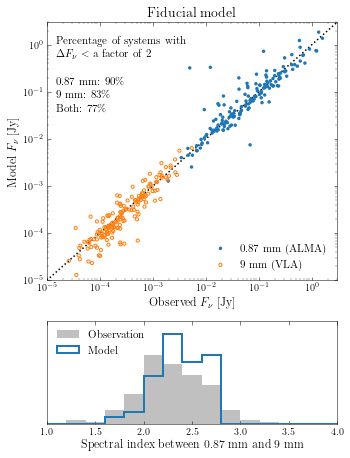

In [9]:
compare_fluxes(F_T20, F_model)
plt.savefig('../figures/flux_comp_fid.pdf',bbox_inches='tight')

alma:0.07, 0.15, 0.36
vla: 0.31, 0.81, 1.57
max: 0.39, 0.86, 1.64
0.8834355828220859
0.5705521472392638
0.5337423312883436
0.10881226555542112
0.7546888515900461
0.819555937057624


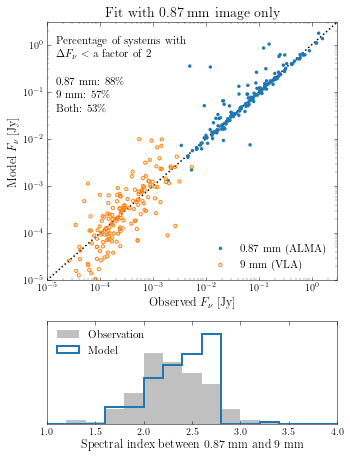

In [10]:
compare_fluxes(F_T20, F_model_alma, 'Fit with 0.87 mm image only')
plt.savefig('../figures/flux_comp_alma.pdf',bbox_inches='tight')

alma:0.09, 0.24, 0.60
vla: 0.17, 0.41, 0.88
max: 0.27, 0.52, 1.19
0.8834355828220859
0.7730061349693251
0.7116564417177914
0.18158105683399195
0.3310857826883016
0.4346112002985054


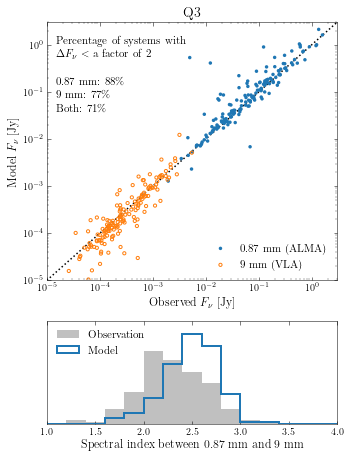

In [11]:
compare_fluxes(F_T20, F_model_Q3, '$Q=3$')